# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Auteurs : Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>


<img src='./Figures/logo_p.jpg' width=200>

## 3. Etude d'un écoulement suite à la chute d'un solide.

### 3.1 Explication de la situation étudiée.

### 3.2 Etude numérique

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.checkTD3 import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *
from src.solidStuffManagement import *

In [2]:
#FLUID PARAMETERS 
e = 0.5 #half width in meters
U = 1 # Upper bound velocity
Re = 1 # Reynolds number
#FLUID PARAMETERS
rhoF = 1000
mu = 200 #(Pa.s)
print(mu)
grav = np.array([0.0,-9.81])#np.array([0.0,-9.81])#np.array([0.0,0.0]) #m.s-2#OTHER FLUID PARAMETERS
c0 = 10*U
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF


200


In [3]:
#GEOMETRY
Lx = 2
Ly = 2
lx = 0.5
ly=1
#PARTICLES & SPACES PARAMETERS : 
dr = ly/20
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#SOLID PARAMETERS
ls = 0.4
ws = 0.2
rhoS = 100
ms = dr*dr*rhoS 
print(ms)
#COMPUTATION DOMAIN : 
xOrigin = -nBound*dr
yOrigin = -nBound*dr
xSize = Lx+2*nBound*dr
ySize = Ly+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize
#INIT SPACES & PART:
posSpace,neibSpace,partSpace,listNeibSpace = \
init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
part = init_particles()

0.25000000000000006


In [4]:
#INIT PART:
#% COMPLETE HERE
part = addBox(part,[Lx,Ly/2],FLUID,dr,rhoF)
part = addBox(part,[-nBound*dr,-nBound*dr,Lx+2*nBound*dr,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[-nBound*dr,0,nBound*dr,Ly],BOUND,dr,rhoF)
part = addBox(part,[Lx,0,nBound*dr,Ly],BOUND,dr,rhoF)
numberOfNonSolidParticles = len(part)
part = addBox(part,[(Lx-ws)/2, (Ly-ls), ws, ls], MOBILESOLID, dr, rhoS)
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
numberOfSolidPart = len(part)-numberOfNonSolidParticles
# END

<IPython.core.display.Javascript object>


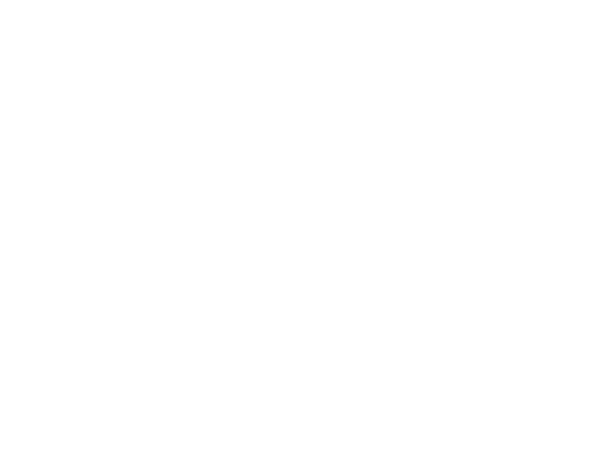

In [5]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

In [6]:
plotSpaces(posSpace,'k',lspace,1)
neibSpace[2][neibSpace[2]>-1]
spacesOutline(posSpace[neibSpace[2][neibSpace[2]>-1]],'r',lspace,1)

Initialisation de la pression

In [7]:
def initWaterPressure(part):
    infoTab = part[:,INFO]
    y_i = part[infoTab == FLUID] [:,POS[1]]
    p_i = np.linalg.norm(grav)*rhoF*(Ly/2-y_i)
    rho_i = density(p_i,B,rhoF,gamma)
    part[infoTab == FLUID, RHO] = rho_i
    return part

<IPython.core.display.Javascript object>


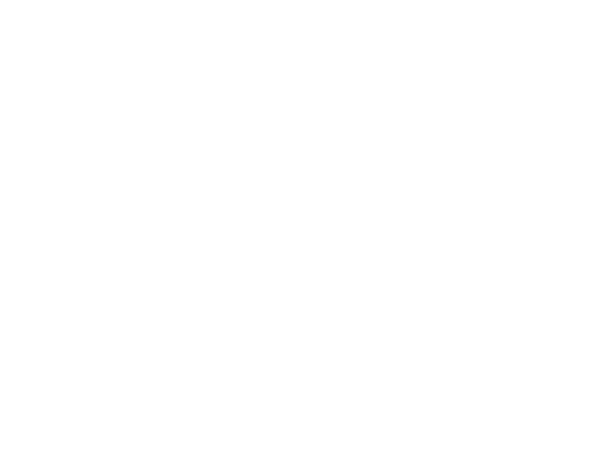

In [8]:
part = initWaterPressure(part)
%matplotlib notebook
Pmax= rhoF*np.linalg.norm(grav)*Ly/2
tabPres = pressure(part[:,RHO],B,rhoF,gamma)
domain = [xOrigin,xMax,yOrigin,yMax,0,Pmax]
plotPropertiesWithBound(part,tabPres,r'Pressure',domain,dr,1)

In [9]:
#Managing the center of mass
#OG = computeCenterOfMass(part, numberOfSolidPart)
infoTab = part[:,INFO]
OG = np.array([1/numberOfSolidPart*np.sum(part[infoTab == MOBILESOLID] [:,POS[0]]),1/numberOfSolidPart*np.sum(part[infoTab == MOBILESOLID] [:,POS[1]])])
print(OG)
V_OG = np.array([0,0])
A_OG = np.array([0,0])

[1.  1.8]


In [10]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Floating_solid_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

In [11]:
# Here we specify the output frequencies
dt_figure = 0.005#0.025*e**2*rhoF/mu
t_print = 0
#final time :
t_end = 3
t=0
it=0
im_count=0

### 3.3 Simulation SPH

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00e+00 -9.81e-06] [ 0.      -0.00981]


<IPython.core.display.Javascript object>


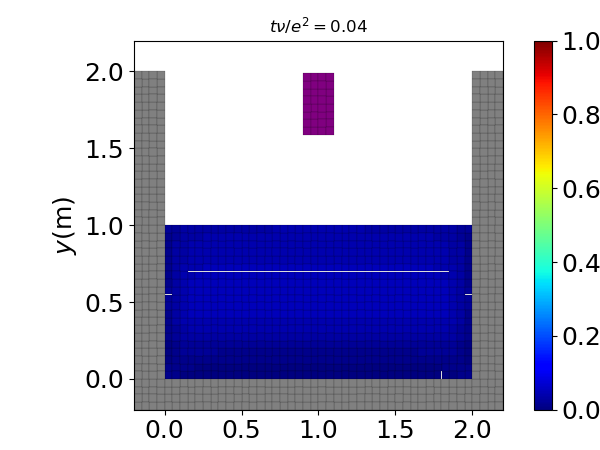

Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -1.95911669e-05] [ 0.         -0.01961039]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -2.92672347e-05] [ 0.         -0.02938205]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -3.88586292e-05] [ 0.         -0.03912521]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.0000000e+00 -4.8366654e-05] [ 0.         -0.04884011]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -5.77925126e-05] [ 0.       -0.058527]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -6.71373839e-05] [ 0.         -0.06818612]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -7.64024233e-05] [ 0.        -0.0778177]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -8.55887634e-05] [ 0.         -0.08742199]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.00000000e+00 -9.46975141e-05] [ 0.         -0.09699921]
Force fluid -> solid :
[0. 0.]
dOG, V_OG :
[ 0.         -0.00010373] [ 0.        

In [ ]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] = interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP2BIS : Interpolation des conditions au bord sur les mobiles bound
    part[:,RHO], part[:, VEL] = interpolateMobileSolidBoundary((part[:,INFO]==MOBILESOLID),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,V_OG,A_OG,shepardMin)
    
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesMorris((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu)
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt)
    #STEP4BIS : integration en temps des particules du solid
    OG, V_OG,A_OG = IntegrateCenterOfMassMovement((part[:,INFO]==MOBILESOLID),\
                                            part[:,SPID],\
                                            part[:,POS],\
                                            part[:,VEL],\
                                            part[:,RHO],\
                                            listNeibSpace,\
                                            aW,h,m,ms,B,rhoF,rhoS,gamma,grav,mu,OG,V_OG,A_OG,part,numberOfSolidPart,dt)

    part[:,POS],part[:,VEL] = MoveSolidParticles((part[:,INFO]==MOBILESOLID),\
                                                part[:,POS],\
                                                part[:,VEL],\
                                                OG,V_OG)
    print("dOG, V_OG :")
    print(OG, V_OG)
    
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t\nu/e^2 = %2.2f$'%(t*mu/rhoF/e**2))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$U_{mag}$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)        
        plt.pause(0.01)
        im_count = im_count+1
        t_print +=dt_figure
        

### 3.4 Etude des résultats 